# Web Scraping + Image Processing

#### imports

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, VBox, Output


In [2]:
print("Working directory:", os.getcwd())

Working directory: c:\Users\bbuser\Desktop\DataScience-Brain-Bytes-1\Team_members\from_arwa


#### Scrape an RGB image from a target webpage

In [3]:

# Create directory to save images
image_dir = "data\\turtle_images"
os.makedirs(image_dir, exist_ok=True)

# Load main frame and extract iframe URL
base_url = "https://scrapethissite.com"
main_url = base_url + "/pages/frames/"

main_response = requests.get(main_url)
main_soup = BeautifulSoup(main_response.text, "html.parser")

iframe_src = main_soup.find("iframe")["src"]
iframe_url = base_url + iframe_src

# Get turtle links from iframe
response = requests.get(iframe_url)
soup = BeautifulSoup(response.text, "html.parser")

turtle_links = soup.select('a[href*="family="]')
turtle_image_data = []

# Visit each detail page and extract data
for link in turtle_links:
    relative_url = link["href"]
    full_url = base_url + relative_url

    detail_response = requests.get(full_url)
    detail_soup = BeautifulSoup(detail_response.text, "html.parser")

    name = detail_soup.select_one("h3.family-name").get_text(strip=True)
    nickname = detail_soup.select_one("strong.common-name")
    nickname = nickname.get_text(strip=True) if nickname else "Unknown"

    description = detail_soup.select_one("p.lead")
    description = description.get_text(strip=True) if description else "No description"

    # Extract image URL
    img_element = detail_soup.select_one("img.turtle-image")
    image = "No image available"
    
    if img_element and img_element.has_attr('src'):
        image_url = img_element['src']
        image_filename = f"turtle_{name.lower().replace(' ', '_')}.jpg"
        image_path = os.path.join(image_dir, image_filename)

        try:
            img_response = requests.get(image_url)
            if img_response.status_code == 200:
                with open(image_path, 'wb') as f:
                    f.write(img_response.content)
                image = image_path
        except Exception as e:
            print(f"Failed to download image for {name}: {e}")
            image = "No image available"

    # Extract year and discoverer
    year = "Unknown"
    discoverer = "Unknown"
    if "discovered in" in description:
        parts = description.split("discovered in")
        if len(parts) > 1:
            right = parts[1].strip().split(" by ")
            if len(right) == 2:
                year = right[0].strip()
                discoverer = right[1].strip().rstrip(".")

    turtle_image_data.append({
        "Name": name,
        "Nickname": nickname,
        "Description": description,
        "Year Discovered": year,
        "Discovered By": discoverer,
        "Image": image
    })

# Display as DataFrame
df = pd.DataFrame(turtle_image_data)
display(df)


,Name,Nickname,Description,Year Discovered,Discovered By,Image
0,Carettochelyidae,Pig-nosed turtle,TheCarettochelyidaefamily of turtles — more co...,1887,Boulenger,No image available
1,Cheloniidae,Sea turtles,TheCheloniidaefamily of turtles — more commonl...,1811,Oppel,No image available
2,Chelydridae,Snapping turtles,TheChelydridaefamily of turtles — more commonl...,1831,Gray,No image available
3,Dermatemydidae,Central American river turtle,TheDermatemydidaefamily of turtles — more comm...,1870,Gray,No image available
4,Dermochelyidae,Leatherback sea turtle,TheDermochelyidaefamily of turtles — more comm...,1843,Fitzinger,No image available
5,Emydidae,Pond or water turtles,TheEmydidaefamily of turtles — more commonly k...,1815,Rafinesque,No image available
6,Geoemydidae,"Asian river, leaf, roofed or Asian box turtles",TheGeoemydidaefamily of turtles — more commonl...,1868,Theobald,No image available
7,Kinosternidae,Mud or musk turtles,TheKinosternidaefamily of turtles — more commo...,1857,Agassiz,No image available
8,Platysternidae,Big-headed turtle,ThePlatysternidaefamily of turtles — more comm...,1869,Gray,No image available
9,Testudinidae,Tortoises,TheTestudinidaefamily of turtles — more common...,1788,Batsch,No image available


In [4]:
# display images
from IPython.display import HTML

def path_to_image_html(path):
    return f'<img src="{path}" width="100"/>'

# Display the table with images
HTML(df.to_html(escape=False, formatters={'Image': path_to_image_html}))


,Name,Nickname,Description,Year Discovered,Discovered By,Image
0,Carettochelyidae,Pig-nosed turtle,"TheCarettochelyidaefamily of turtles — more commonly known as ""Pig-nosed turtle"" — were first discovered in 1887 by Boulenger.",1887,Boulenger,
1,Cheloniidae,Sea turtles,"TheCheloniidaefamily of turtles — more commonly known as ""Sea turtles"" — were first discovered in 1811 by Oppel.",1811,Oppel,
2,Chelydridae,Snapping turtles,"TheChelydridaefamily of turtles — more commonly known as ""Snapping turtles"" — were first discovered in 1831 by Gray.",1831,Gray,
3,Dermatemydidae,Central American river turtle,"TheDermatemydidaefamily of turtles — more commonly known as ""Central American river turtle"" — were first discovered in 1870 by Gray.",1870,Gray,
4,Dermochelyidae,Leatherback sea turtle,"TheDermochelyidaefamily of turtles — more commonly known as ""Leatherback sea turtle"" — were first discovered in 1843 by Fitzinger.",1843,Fitzinger,
5,Emydidae,Pond or water turtles,"TheEmydidaefamily of turtles — more commonly known as ""Pond or water turtles"" — were first discovered in 1815 by Rafinesque.",1815,Rafinesque,
6,Geoemydidae,"Asian river, leaf, roofed or Asian box turtles","TheGeoemydidaefamily of turtles — more commonly known as ""Asian river, leaf, roofed or Asian box turtles"" — were first discovered in 1868 by Theobald.",1868,Theobald,
7,Kinosternidae,Mud or musk turtles,"TheKinosternidaefamily of turtles — more commonly known as ""Mud or musk turtles"" — were first discovered in 1857 by Agassiz.",1857,Agassiz,
8,Platysternidae,Big-headed turtle,"ThePlatysternidaefamily of turtles — more commonly known as ""Big-headed turtle"" — were first discovered in 1869 by Gray.",1869,Gray,
9,Testudinidae,Tortoises,"TheTestudinidaefamily of turtles — more commonly known as ""Tortoises"" — were first discovered in 1788 by Batsch.",1788,Batsch,


#### 2. Apply Advanced Histogram Analysis

Display individual Red, Green, Blue histograms.


In [5]:
image_folder = ".\\data\\turtle_images"

image_records = []
for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(image_folder, filename)
        name = filename.replace("turtle_", "").replace(".jpg", "").capitalize()
        image_records.append((path, name))

image_records.sort()

out = Output()
index = {"value": 0}

def show_image(idx):
    with out:
        clear_output(wait=True)
        img_path, name = image_records[idx]
        img = Image.open(img_path)
        display(f"Turtle: {name}")
        display(img)

def on_next_clicked(b):
    if index["value"] < len(image_records) - 1:
        index["value"] += 1
        show_image(index["value"])

def on_prev_clicked(b):
    if index["value"] > 0:
        index["value"] -= 1
        show_image(index["value"])

next_btn = Button(description="Next ▶️", button_style="success")
prev_btn = Button(description="◀️ Previous", button_style="info")

next_btn.on_click(on_next_clicked)
prev_btn.on_click(on_prev_clicked)

controls = HBox([prev_btn, next_btn])
slideshow = VBox([controls, out])

show_image(index["value"])
display(slideshow)

In [6]:
# Folder containing images
image_folder = "data/turtle_images"

# Collect valid images
image_records = []
for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(image_folder, filename)
        name = filename.replace("turtle_", "").replace(".jpg", "").capitalize()
        image_records.append((path, name))

# Output area for UI
out = Output()
index = {"value": 0}

# ---------- Function: Display Image + Histogram ---------- #
def show_image_and_histogram(idx):
    with out:
        clear_output(wait=True)
        img_path, name = image_records[idx]
        img = Image.open(img_path).convert("RGB")

        # Split channels
        r, g, b = img.split()
        r_data = np.array(r).flatten()
        g_data = np.array(g).flatten()
        b_data = np.array(b).flatten()

        # Create side-by-side plots
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Left: Image
        axes[0].imshow(img)
        axes[0].axis("off")
        axes[0].set_title(f"Turtle: {name}")

        # Right: RGB Histogram
        axes[1].hist(r_data, bins=256, color="red", alpha=0.5, label="Red", density=True)
        axes[1].hist(g_data, bins=256, color="green", alpha=0.5, label="Green", density=True)
        axes[1].hist(b_data, bins=256, color="blue", alpha=0.5, label="Blue", density=True)
        axes[1].set_title("Normalized RGB Histogram")
        axes[1].set_xlabel("Pixel Intensity (0–255)")
        axes[1].set_ylabel("Density")
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

# ---------- Buttons ---------- #
def on_next(b):
    if index["value"] < len(image_records) - 1:
        index["value"] += 1
        show_image_and_histogram(index["value"])

def on_prev(b):
    if index["value"] > 0:
        index["value"] -= 1
        show_image_and_histogram(index["value"])

next_btn = Button(description="Next ▶️", button_style="success")
prev_btn = Button(description="◀️ Previous", button_style="info")

next_btn.on_click(on_next)
prev_btn.on_click(on_prev)

# ---------- Display ---------- #
controls = HBox([prev_btn, next_btn])
ui = VBox([controls, out])

show_image_and_histogram(index["value"])
display(ui)

Create and display a combined RGB histogram on the same plot.

Normalize the histograms for comparison.


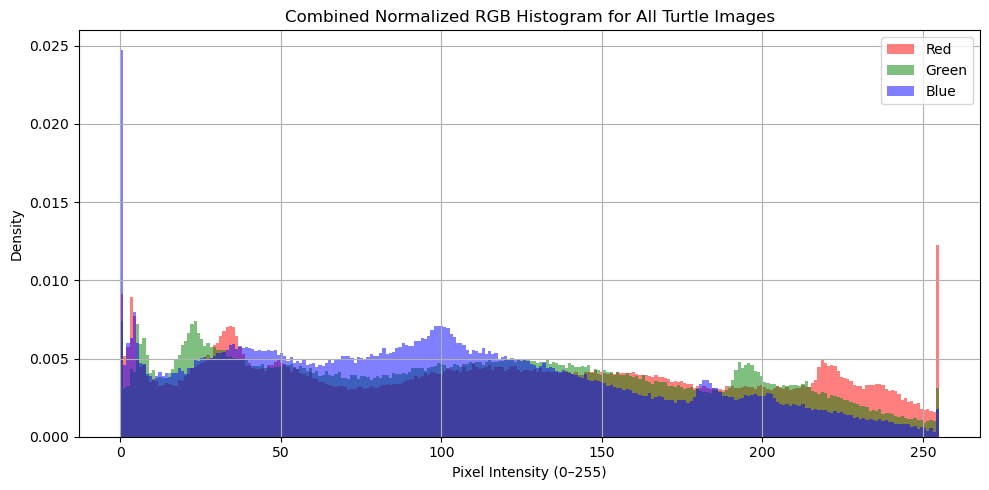

In [7]:
# Set the image folder path
image_folder = "data/turtle_images"

# Prepare lists to store all pixel values
all_r = []
all_g = []
all_b = []

# Loop through all images
for filename in os.listdir(image_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(image_folder, filename)
        try:
            img = Image.open(img_path).convert("RGB")
            r, g, b = img.split()

            all_r.extend(np.array(r).flatten())
            all_g.extend(np.array(g).flatten())
            all_b.extend(np.array(b).flatten())
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

# Plot combined normalized RGB histogram
plt.figure(figsize=(10, 5))
plt.hist(all_r, bins=256, color='red', alpha=0.5, label='Red', density=True)
plt.hist(all_g, bins=256, color='green', alpha=0.5, label='Green', density=True)
plt.hist(all_b, bins=256, color='blue', alpha=0.5, label='Blue', density=True)

plt.title("Combined Normalized RGB Histogram for All Turtle Images")
plt.xlabel("Pixel Intensity (0–255)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 3. Perform Multiple Intensity Transformations

Logarithmic Transformation for contrast enhancement in dark regions.
Gamma Correction with at least two different gamma values.
Contrast Stretching with defined min/max intensity values.


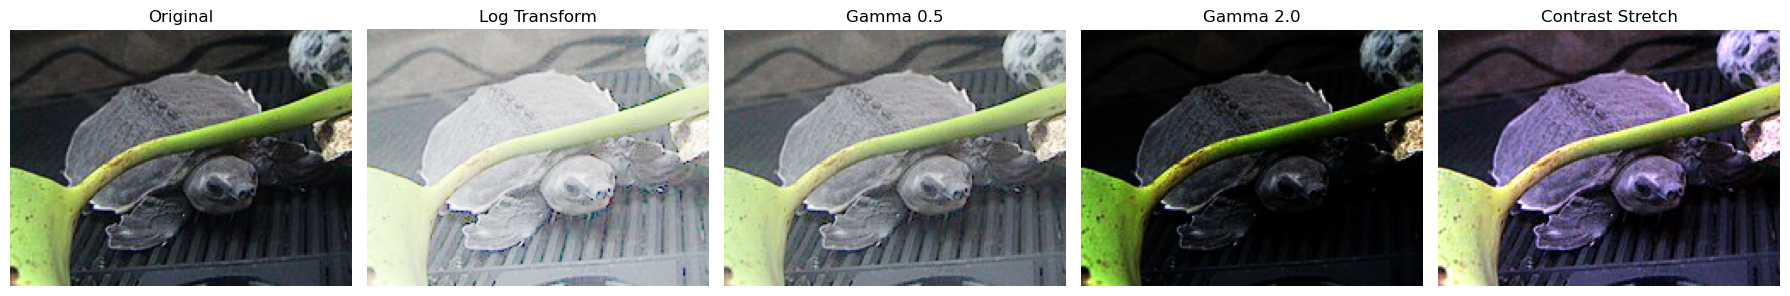

In [11]:
def log_transform(arr):
    arr = np.array(arr, dtype=np.float32)
    c = 255 / np.log1p(255)
    return np.clip(c * np.log1p(arr), 0, 255).astype(np.uint8)

def gamma_correction(arr, gamma):
    arr = np.array(arr, dtype=np.float32) / 255.0
    return np.clip(np.power(arr, gamma) * 255, 0, 255).astype(np.uint8)

def contrast_stretch(arr, in_min, in_max):
    arr = np.array(arr, dtype=np.float32)
    return np.clip((arr - in_min) * (255 / (in_max - in_min)), 0, 255).astype(np.uint8)

# Use first image
img_path, img_name = image_records[0]
img = Image.open(img_path).convert("RGB")
r, g, b = img.split()
shape = np.array(r).shape

# Transformations
log_img = np.stack([log_transform(r), log_transform(g), log_transform(b)], axis=-1)
gamma_img_05 = np.stack([gamma_correction(r, 0.5), gamma_correction(g, 0.5), gamma_correction(b, 0.5)], axis=-1)
gamma_img_20 = np.stack([gamma_correction(r, 2.0), gamma_correction(g, 2.0), gamma_correction(b, 2.0)], axis=-1)
cs_img = np.stack([
    contrast_stretch(r, np.percentile(r, 2), np.percentile(r, 98)),
    contrast_stretch(g, np.percentile(g, 2), np.percentile(g, 98)),
    contrast_stretch(b, np.percentile(b, 2), np.percentile(b, 98))
], axis=-1)

# Plot
titles = ["Original", "Log Transform", "Gamma 0.5", "Gamma 2.0", "Contrast Stretch"]
images = [np.array(img), log_img, gamma_img_05, gamma_img_20, cs_img]

plt.figure(figsize=(18, 6))
for i, (im, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 5, i+1)
    plt.imshow(im.astype(np.uint8))
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()


#### 4. Apply Histogram Equalization

Equalize each RGB channel separately.
Equalize the luminance channel in YCrCb or LAB space while preserving colors.

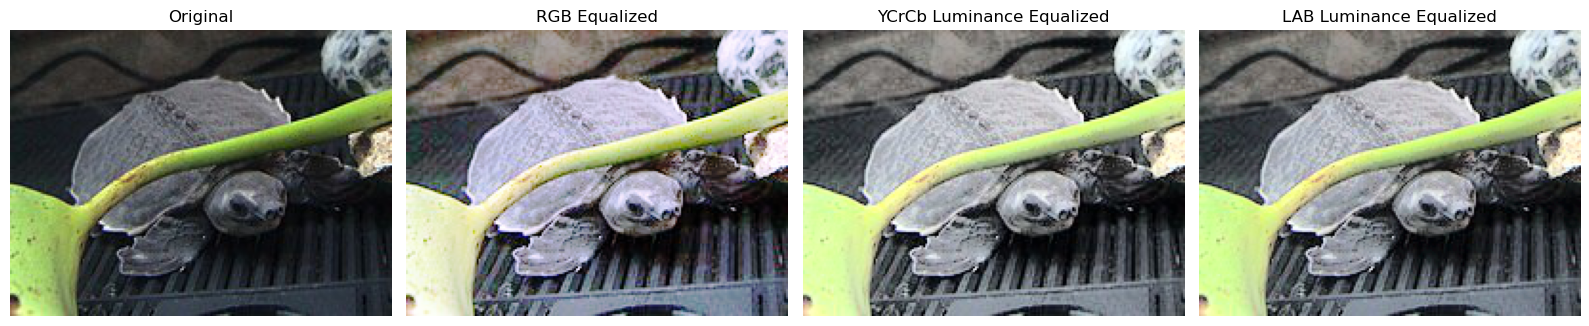

In [12]:
# Equalize each RGB channel separately
def equalize_rgb_channels(img):
    r, g, b = img.split()
    r_eq = Image.fromarray(cv2.equalizeHist(np.array(r)))
    g_eq = Image.fromarray(cv2.equalizeHist(np.array(g)))
    b_eq = Image.fromarray(cv2.equalizeHist(np.array(b)))
    return Image.merge("RGB", (r_eq, g_eq, b_eq))

# Equalize luminance channel in YCrCb space
def equalize_luminance_ycrcb(img):
    img_np = np.array(img)
    img_ycrcb = cv2.cvtColor(img_np, cv2.COLOR_RGB2YCrCb)
    img_ycrcb[:, :, 0] = cv2.equalizeHist(img_ycrcb[:, :, 0])
    img_eq = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2RGB)
    return Image.fromarray(img_eq)

# Equalize luminance channel in LAB space
def equalize_luminance_lab(img):
    img_np = np.array(img)
    img_lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    img_lab[:, :, 0] = cv2.equalizeHist(img_lab[:, :, 0])
    img_eq = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    return Image.fromarray(img_eq)

# Use first image for demonstration
img_path, img_name = image_records[0]
img = Image.open(img_path).convert("RGB")

rgb_eq_img = equalize_rgb_channels(img)
ycrcb_eq_img = equalize_luminance_ycrcb(img)
lab_eq_img = equalize_luminance_lab(img)

# Display results
titles = ["Original", "RGB Equalized", "YCrCb Luminance Equalized", "LAB Luminance Equalized"]
images = [img, rgb_eq_img, ycrcb_eq_img, lab_eq_img]

plt.figure(figsize=(16, 5))
for i, (im, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()

#### 5. Thresholding and Segmentation

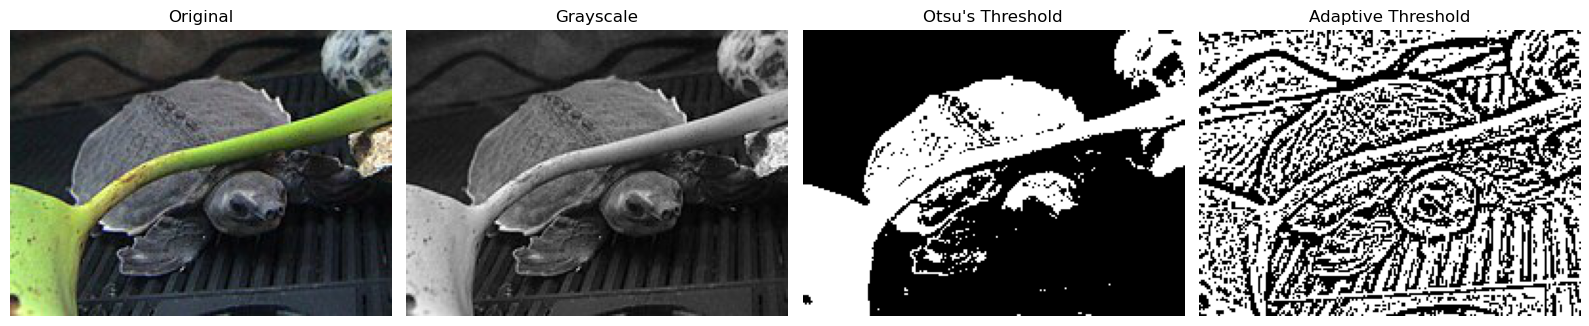

In [13]:
# Convert to grayscale
def to_grayscale(img):
    img_np = np.array(img)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return Image.fromarray(gray)

# Otsu's thresholding
def otsu_threshold(img):
    img_np = np.array(img.convert("L"))  # ensure grayscale
    _, otsu = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return Image.fromarray(otsu)

# Adaptive thresholding (Gaussian)
def adaptive_threshold(img):
    img_np = np.array(img.convert("L"))
    adaptive = cv2.adaptiveThreshold(img_np, 255,
                                     cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    return Image.fromarray(adaptive)

# Use first image for demonstration
img_path, img_name = image_records[0]
img = Image.open(img_path).convert("RGB")

gray_img = to_grayscale(img)
otsu_img = otsu_threshold(img)
adaptive_img = adaptive_threshold(img)

# Display results
titles = ["Original", "Grayscale", "Otsu's Threshold", "Adaptive Threshold"]
images = [img, gray_img, otsu_img, adaptive_img]

plt.figure(figsize=(16, 5))
for i, (im, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(im, cmap="gray" if title != "Original" else None)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()


#### 6. Visualization Layout

Show original vs transformed images side-by-side.
Show histograms before and after transformations.
Arrange results in a multi-row subplot for easy comparison.

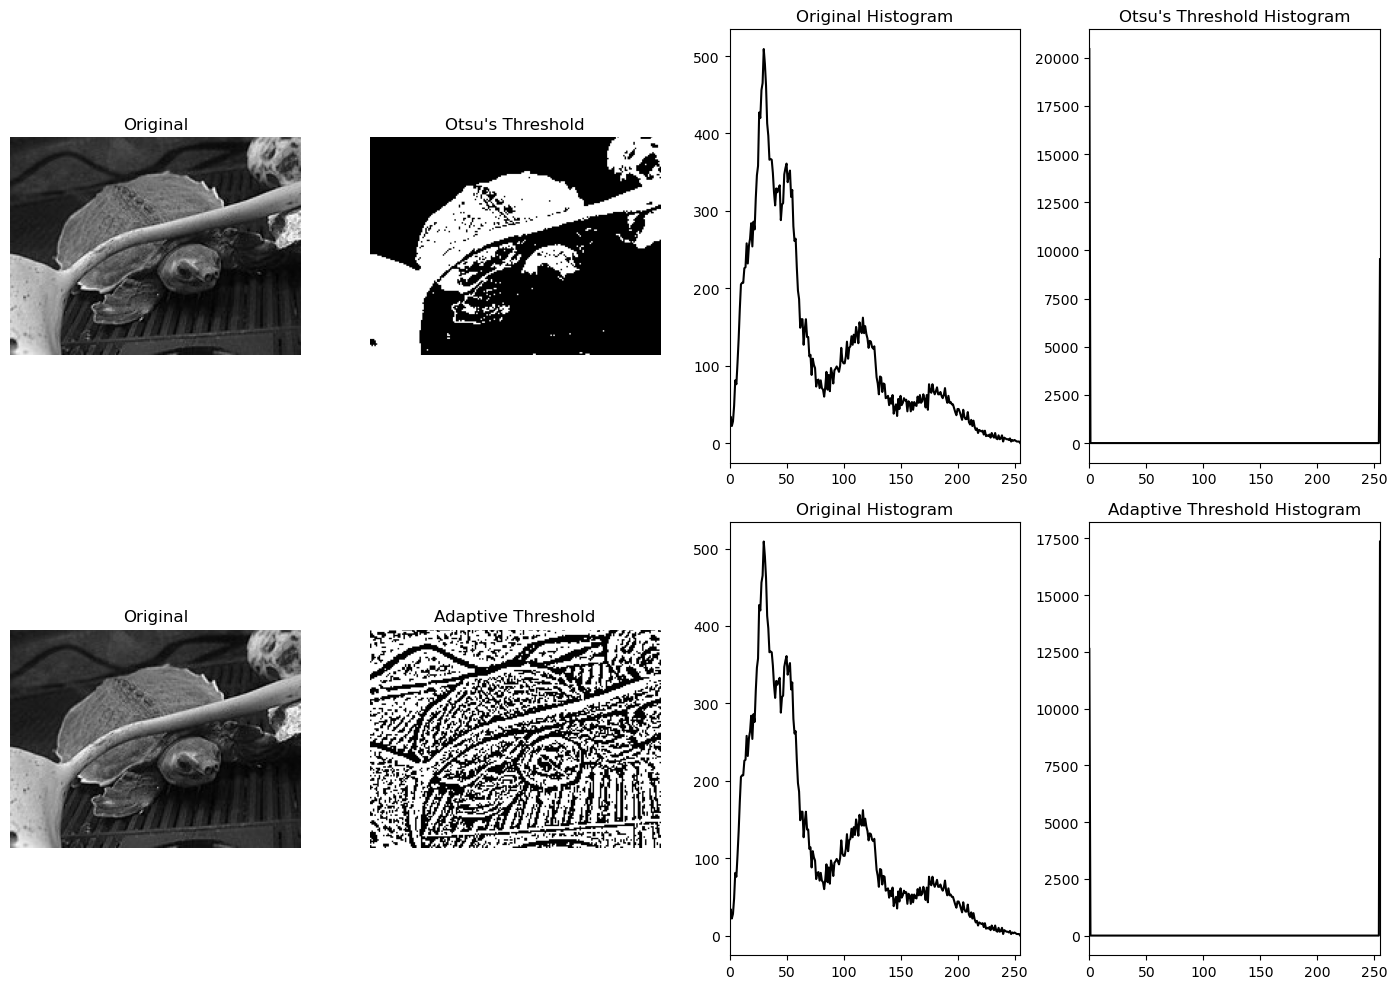

In [15]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# --- Load image ---
img_path, img_name = image_records[0]
img = Image.open(img_path).convert("RGB")
gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

# --- Transformations ---
_, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
adaptive = cv2.adaptiveThreshold(gray, 255,
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

# --- Histogram helper ---
def hist(arr, bins=256):
    h, b = np.histogram(arr.ravel(), bins=bins, range=(0, 256))
    return h, b

orig_hist, orig_bins = hist(gray)

# --- Methods to compare ---
methods = [
    ("Otsu's Threshold", otsu),
    ("Adaptive Threshold", adaptive)
]

# --- Plot: rows = methods, cols = 4 (Original | Transformed | Original Hist | Transformed Hist) ---
fig, axes = plt.subplots(len(methods), 4, figsize=(14, 5 * len(methods)))

for r, (title, transformed) in enumerate(methods):
    # Original image
    axes[r, 0].imshow(gray, cmap="gray")
    axes[r, 0].set_title("Original")
    axes[r, 0].axis("off")

    # Transformed image
    axes[r, 1].imshow(transformed, cmap="gray")
    axes[r, 1].set_title(title)
    axes[r, 1].axis("off")

    # Original histogram
    axes[r, 2].plot(orig_bins[:-1], orig_hist, color="black")
    axes[r, 2].set_title("Original Histogram")
    axes[r, 2].set_xlim([0, 255])

    # Transformed histogram
    th, tb = hist(transformed)
    axes[r, 3].plot(tb[:-1], th, color="black")
    axes[r, 3].set_title(f"{title} Histogram")
    axes[r, 3].set_xlim([0, 255])

plt.tight_layout()
plt.show()


#### 7. Interactive Gamma Slider (using matplotlib widget)


In [19]:
img_path, img_name = image_records[0]
img = np.array(Image.open(img_path).convert("RGB"))

def adjust_show(gamma=1.0, brightness=0):
    x = img.astype(np.float32)/255.0
    x = np.power(x, 1.0/max(gamma,1e-6))
    x = np.clip(x + (brightness/255.0), 0, 1)
    out = (x*255).astype(np.uint8)

    gray_o = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_t = cv2.cvtColor(out, cv2.COLOR_RGB2GRAY)

    plt.figure(figsize=(10,8))
    # Top row: images
    plt.subplot(2,2,1); plt.imshow(img); plt.title("Original");   plt.axis("off")
    plt.subplot(2,2,2); plt.imshow(out); plt.title("Transformed"); plt.axis("off")
    # Bottom row: histograms
    plt.subplot(2,2,3); plt.hist(gray_o.ravel(), bins=256, range=(0,256)); plt.title("Original Hist")
    plt.subplot(2,2,4); plt.hist(gray_t.ravel(), bins=256, range=(0,256)); plt.title("Transformed Hist")
    plt.tight_layout(); plt.show()

interact(
    adjust_show,
    gamma=FloatSlider(min=0.2, max=3.0, step=0.01, value=1.0, description='Gamma'),
    brightness=IntSlider(min=-100, max=100, step=1, value=0, description='Brightness')
)

interactive(children=(FloatSlider(value=1.0, description='Gamma', max=3.0, min=0.2, step=0.01), IntSlider(valu…

<function __main__.adjust_show(gamma=1.0, brightness=0)>